### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import *

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-03-09 17:06:16.036152: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 17:06:16.036439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 17:06:16.136158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 17:06:16.295847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-09 17:06:25.176321: W tensorflow/comp

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [2]:
dataset_dir = "/home/ppxst5/mlis2_project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm_cleaned_7.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["angle"], inplace=True)

display(csv_df)

,speed
image_id,
1,0.0
2,1.0
3,1.0
4,1.0
5,0.0
...,...
13794,1.0
13795,1.0
13796,0.0


Check the data

(array([ 3459.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 10332.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

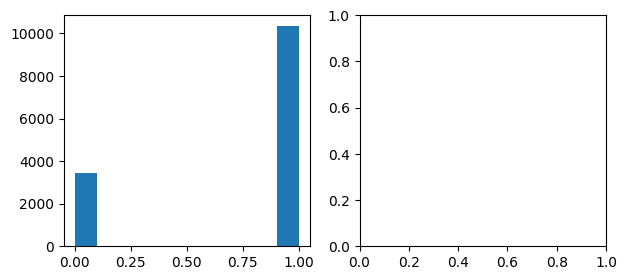

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[0].hist(csv_df["speed"])

In [4]:
# for rs in range(10000):
#     X = np.array(csv_df.index)
#     y = np.array(csv_df['speed'])
#     X_train, X_val, y_train, y_val = train_test_split(
#         X, y, test_size=0.15, random_state=rs
#     )

#     # print(X_train.shape)
#     # print(X_val.shape)
#     # print(X_test.shape)
#     # print(X.shape)

#     train_count = pd.Series(y_train).value_counts()
#     train_count = train_count / sum(train_count) * 100
#     # val_count = pd.Series(y_val).value_counts()
#     # val_count = val_count / sum(val_count) * 100
#     # test_count = pd.Series(y_test).value_counts()
#     # test_count = test_count / sum(test_count) * 100

#     ori_count = pd.Series(y).value_counts()
#     ori_count = ori_count / sum(ori_count) * 100

#     diff = (sum(abs(train_count-ori_count)))

#     if (diff < 0.01):
#         print(f"random state: {rs:4d} | diff: {diff:.8f}")

#     bar_width = 0.015
#     # plt.bar(val_count.index-bar_width, train_count, width=bar_width)
#     # plt.bar(train_count.index, train_count, width=bar_width)
#     # plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
#     # plt.bar(test_count.index+bar_width, train_count, width=bar_width)

# # random state:   89 | diff: 0.00106150
# # random state:  132 | diff: 0.00106150
# # random state:  145 | diff: 0.00106150
# # random state:  257 | diff: 0.00106150
# # random state:  329 | diff: 0.00106150
# # random state:  370 | diff: 0.00106150
# # random state:  398 | diff: 0.00106150
# # random state:  448 | diff: 0.00106150
# # random state:  449 | diff: 0.00106150
# # random state:  470 | diff: 0.00106150
# # random state:  488 | diff: 0.00106150
# # random state:  522 | diff: 0.00106150
# # random state:  528 | diff: 0.00106150
# # random state:  566 | diff: 0.00106150
# # random state:  607 | diff: 0.00106150
# # random state:  666 | diff: 0.00106150
# # random state:  783 | diff: 0.00106150
# # random state:  789 | diff: 0.00106150

398 0.0010614995343587452


<BarContainer object of 2 artists>

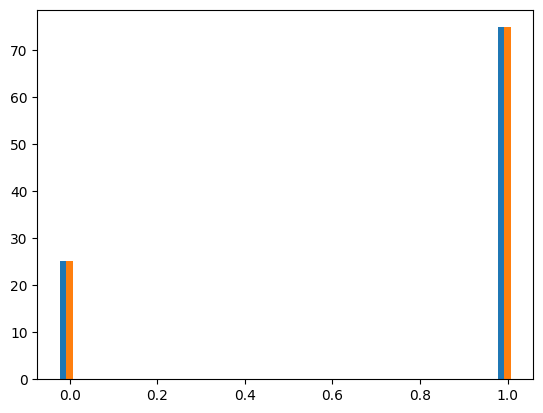

In [5]:
rs = 398

X = np.array(csv_df.index)
y = np.array(csv_df["speed"])
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.15, random_state=rs
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
# )
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=rs
)

train_count = pd.Series(y_train).value_counts()
train_count = train_count / sum(train_count) * 100
val_count = pd.Series(y_val).value_counts()
val_count = val_count / sum(val_count) * 100
# test_count = pd.Series(y_test).value_counts()
# test_count = test_count / sum(test_count) * 100

# print(train_count)
# print(val_count)
# print(test_count)

ori_count = pd.Series(y).value_counts()
ori_count = ori_count / sum(ori_count) * 100

# print(ori_count)

diff = sum(abs(train_count - ori_count))

# diff = (abs(train_count[0] - test_count[0]) + abs(train_count[0]-val_count[0]))

print(rs, diff)



# if diff < 0.7:
#     print(f"random state: {rs}")
#     print(diff)

bar_width = 0.015
plt.bar(val_count.index - bar_width, train_count, width=bar_width)
plt.bar(train_count.index, train_count, width=bar_width)
# plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
# plt.bar(test_count.index + bar_width, train_count, width=bar_width)

In [6]:
# sample_probs_tensor = tf.constant(p_for_random_choice, dtype=tf.float32)

# X_train_tensor = tf.constant(X_train, dtype=tf.int32)
# y_train_tensor = tf.constant(y_train, dtype=tf.float32)

# NUM_SAMPLES = 32*400

# def sample_indices():
#     return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

# sampled_indices = sample_indices()

# X_train_os = tf.gather(X_train_tensor, sampled_indices)
# y_train_os = tf.gather(y_train_tensor, sampled_indices)

# train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

In [7]:
# ids = []
# angles = []
# for id, angle in train_ds:
#     ids.append(id.numpy())
#     angles.append(angle.numpy())

In [8]:
# y_count = pd.Series(angles).value_counts().sort_index()
# plt.bar(y_count.index, y_count, width=0.04)
# plt.title("Distribution of angles after oversampling")

In [9]:
X_train_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_train
]
X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

In [10]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, speed):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, speed

def image_id_to_path(image_id, speed):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, speed

In [11]:

train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

11722
2069


2025-03-09 17:06:44.662535: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9790 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


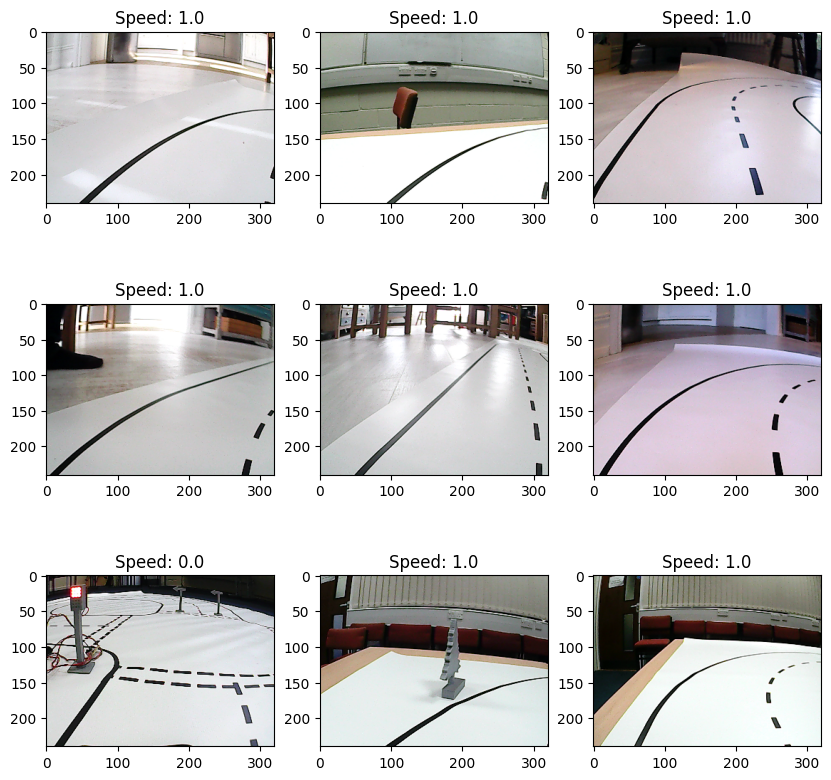

In [12]:
plt.figure(figsize=(10, 10))
i = 0

for image, speed in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    speed = speed.numpy()
    plt.title(f"Speed: {speed}")
    i += 1

In [13]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [14]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, speed, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, speed

Test augment function

20


2025-03-09 17:06:46.398459: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Augmented image shape: (240, 320, 3)


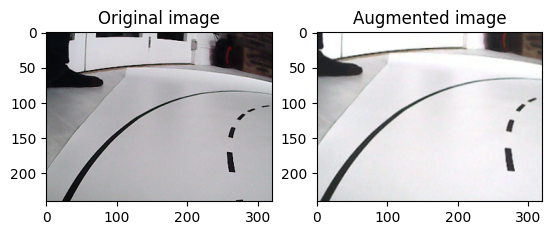

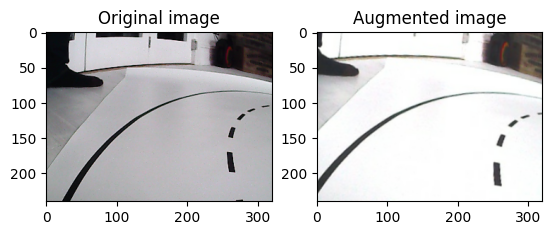

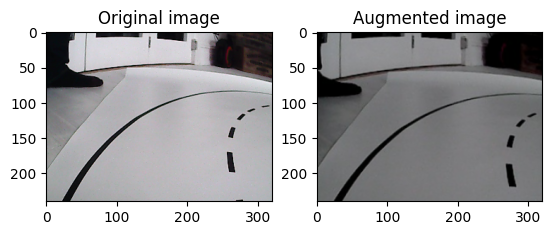

In [15]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, speed in train_ds.skip(skip).take(1):
        augmented_image, speed = augment(image, speed, None)
        visualise(image, augmented_image)

for image, speed in train_ds.take(1):
    aug_image, aug_speed = augment(image, speed)
    print(f"Augmented image shape: {aug_image.shape}")

In [16]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [17]:
# def enhance_red(image, speed):
#     r, g, b = tf.split(image, num_or_size_splits=3, axis=-1)
#     r_mask = tf.logical_and((r*0.9 > g), (r*0.9 > b))
#     g_mask = tf.logical_and((g > r), (g > b))
#     b_mask = tf.logical_and((b > r), (b > g))
#     r = tf.where(r_mask, tf.clip_by_value(r * 1.5, 0.0, 1.0), r)
#     # g = g**2
#     # b = b**2
#     image = tf.concat([r, g, b], axis=-1)
#     return image, speed

# trian_ds = train_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
def scale_ds(image, speed):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, speed


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [19]:
def rephrase_ds(image, speed):
    # return image, {"speed1_output": speed, "speed2_output": speed, "speed3_output": speed}
    speed_dict = {}
    for i in range(10):
        speed_dict[f"speed{i}_output"] = speed

    return image, speed_dict

train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
batch_size = 64


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [21]:
print(y_train)
class_weight = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weight[0], 1: class_weight[1]}
print(class_weight_dict)

[1. 1. 1. ... 1. 1. 1.]
{0: 1.9935374149659864, 1: 0.6673878387611023}


In [22]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

print(base_model.output.shape)

(None, 8, 10, 960)


In [23]:
feature_extractor = base_model.output

print(feature_extractor.shape)

s_model = []

output_activation_1 = 'sigmoid'
output_activation_2 = 'linear'


# model 0
i = 0

s = feature_extractor
s = layers.Conv2D(138, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_2')(feature_extractor)
s = layers.BatchNormalization(name=f's{i}_bn_2')(s)
s = layers.Activation('relu', name=f's{i}_relu_2')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)
s = layers.Dense(256, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 1
i += 1

s = feature_extractor
s = layers.Conv2D(496, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(feature_extractor)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Conv2D(86, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_2')(s)
s = layers.BatchNormalization(name=f's{i}_bn_2')(s)
s = layers.Activation('relu', name=f's{i}_relu_2')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(96, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 2
i += 1

s = feature_extractor
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])
s = layers.Conv2D(128, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)
s = layers.Dense(384, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(96, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 3
i += 1

s = feature_extractor
s = layers.Conv2D(64, (3, 3), (2, 2), padding='same', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(86, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(32, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.4, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 4
i += 1

s = feature_extractor
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])

# Spatial pyramid pooling
pool1 = layers.AveragePooling2D(pool_size=(1, 1), name=f's{i}_pool_1')(s)  # Full size
pool2 = layers.AveragePooling2D(pool_size=(2, 2), name=f's{i}_pool_2')(s)
up1 = layers.UpSampling2D(size=(1, 1), name=f's{i}_up_1')(pool1)
up2 = layers.UpSampling2D(size=(2, 2), name=f's{i}_up_2')(pool2)
s = layers.Concatenate(name=f's{i}_concat')([up1, up2])

s_up = s

# Conv to reduce channels
s = layers.Conv2D(64, (3, 3), padding='same', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)

# Dense layers
s = layers.Dense(56, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.4, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)



# model 5
i += 1

s = feature_extractor
# Spatial pyramid pooling
pool1 = layers.AveragePooling2D(pool_size=(1, 1), name=f's{i}_pool_1')(s)  # Full size
pool2 = layers.AveragePooling2D(pool_size=(2, 2), name=f's{i}_pool_2')(s)
up1 = layers.UpSampling2D(size=(1, 1), name=f's{i}_up_1')(pool1)
up2 = layers.UpSampling2D(size=(2, 2), name=f's{i}_up_2')(pool2)
s = layers.Concatenate(name=f's{i}_concat')([up1, up2])

s_up = s

# Conv to reduce channels
s = layers.Conv2D(64, (3, 3), padding='same', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.GlobalAveragePooling2D(name=f's{i}_GAP')(s)

# Dense layers
s = layers.Dense(32, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 6
i += 1

s = feature_extractor
s = layers.Conv2D(72, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s_up)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)



# model 7
i += 1

s = feature_extractor
s = layers.Conv2D(56, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(128, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


# model 8
i += 1

s = feature_extractor
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])
s = layers.Conv2D(48, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s = layers.Flatten(name=f's{i}_attention_flatten')(s)
s = layers.Dense(48, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(32, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)



# model 9
i += 1

s = feature_extractor
s = layers.Conv2D(56, (3, 3), (2, 2), padding='same', 
                  kernel_initializer='he_uniform', name=f's{i}_conv_1')(s)
s = layers.BatchNormalization(name=f's{i}_bn_1')(s)
s = layers.Activation('relu', name=f's{i}_relu_1')(s)
s_attention = layers.Conv2D(1, (1, 1), padding='same', activation="sigmoid", name=f's{i}_attention_conv')(s)
s = layers.Multiply(name=f's{i}_attention_apply')([s, s_attention])
s = layers.Flatten(name=f's{i}_flatten')(s)
s = layers.Dense(64, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_2')(s)
s = layers.Dropout(0.5, name=f's{i}_dropout_2')(s)
s = layers.Dense(32, activation='relu', kernel_initializer='he_uniform', name=f's{i}_dense_1')(s)
s = layers.Dropout(0.4, name=f's{i}_dropout')(s)
s = layers.Dense(1, activation=output_activation_1, name=f's{i}_output')(s)

s_model.append(s)


outputs_dict = {}
loss_dict = {}
metrics_dict = {}

for i in range(len(s_model)):
    outputs_dict[f'speed{i}_output'] = s_model[i]
    loss_dict[f'speed{i}_output'] = WeightedBinaryCrossEntropy(class_weight_dict)
    # loss_dict[f'speed{i}_output'] = WeightedMeanSquaredError(class_weight_dict)
    metrics_dict[f'speed{i}_output'] = ["mse", "accuracy"]


model = Model(inputs=base_model.input, outputs=outputs_dict, name="speed_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=loss_dict,
    metrics=metrics_dict,
)

# model.summary()

(None, 8, 10, 960)


In [24]:
# sub_model = Model(inputs=feature_extractor, outputs=outputs_dict, 
#                                                 name="speed_model")
# tf.keras.utils.plot_model(
#     sub_model,
#     show_shapes=True,  # Show input/output shapes
#     show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
#     expand_nested=False,  # Keep it flat (no base_model nesting)
#     show_layer_activations=True,
#     dpi=96,  # Image resolution
# )

# print("Saved model image: model.png")

In [25]:
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 2
    
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        return max(initial_lr * 2, 0.002)
    decay = 0.42
    return initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay)

# for epoch in range(100):
#     print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

### Train model

In [26]:
current_epoch = 1
NUM_OF_EPOCHS = 45


checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

# Use this lr_schedule when re-gen data every epoch
def lr_schedule(epoch, lr):
    FIRST_N_EPOCHS = 2
    epoch = current_epoch-1
    initial_lr = learning_rate
    if epoch < FIRST_N_EPOCHS:
        # return 0.002
        return max(initial_lr * 2, 0.002)
    # elif epoch > 46:
    #     return 0.0001
    decay = 0.42
    return max(initial_lr / (1 + ((epoch-FIRST_N_EPOCHS) // 3) * decay), 0.0001)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)


history_callback = keras.callbacks.History()

outputs_dict = {}
loss_dict = {}
metrics_dict = {}

for i in range(len(s_model)):
    outputs_dict[f'speed{i}_output'] = s_model[i]
    loss_dict[f'speed{i}_output'] = WeightedMeanSquaredError(class_weight_dict)
    metrics_dict[f'speed{i}_output'] = ["mse", "accuracy"]

try:
    for i in range(NUM_OF_EPOCHS):
        print(f"\n{50*'*'}\nCurrent epoch: {current_epoch}", end="")

        if current_epoch == 44: # change to WMSE
            print("\nChanging to W-MSE")
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=loss_dict,
                metrics=metrics_dict,
            )

        
        checkpoint = keras.callbacks.ModelCheckpoint(
            filepath=f"checkpoints/model_epoch_{current_epoch:02d}.keras",
            save_weights_only=False,
            save_freq="epoch",
            verbose=1,
        )
    
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=1,
            steps_per_epoch= train_ds_length // batch_size,
            validation_steps= val_ds_length // batch_size,
            callbacks=[checkpoint, history_callback, lr_scheduler],
            verbose=1,
        )

        current_epoch += 1

except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


**************************************************
Current epoch: 1
Epoch 1: LearningRateScheduler setting learning rate to 0.002.


2025-03-09 17:07:02.630210: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-03-09 17:07:03.524114: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-09 17:07:08.391785: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8b3b03c8e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-09 17:07:08.391838: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-03-09 17:07:08.424199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741540028.597103 2212361 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 [==============================] - ETA: 0s - loss: 1.6268 - s0_output_loss: 0.1367 - s1_output_loss: 0.1225 - s2_output_loss: 0.1469 - s3_output_loss: 0.1742 - s4_output_loss: 0.1299 - s5_output_loss: 0.1410 - s6_output_loss: 0.1888 - s7_output_loss: 0.1783 - s8_output_loss: 0.2541 - s9_output_loss: 0.1543 - s0_output_mse: 0.0393 - s0_output_accuracy: 0.9454 - s1_output_mse: 0.0338 - s1_output_accuracy: 0.9551 - s2_output_mse: 0.0430 - s2_output_accuracy: 0.9419 - s3_output_mse: 0.0505 - s3_output_accuracy: 0.9304 - s4_output_mse: 0.0371 - s4_output_accuracy: 0.9497 - s5_output_mse: 0.0399 - s5_output_accuracy: 0.9495 - s6_output_mse: 0.0552 - s6_output_accuracy: 0.9230 - s7_output_mse: 0.0516 - s7_output_accuracy: 0.9283 - s8_output_mse: 0.0778 - s8_output_accuracy: 0.8936 - s9_output_mse: 0.0457 - s9_output_accuracy: 0.9373
Epoch 1: saving model to checkpoints/model_epoch_01.keras
183/183 [==============================] - 57s 165ms/step - loss: 1.6268 - s0_output_loss: 0.136

In [27]:
# for i in range(len(s_model)):
#     outputs_dict[f'speed{i}_output'] = s_model[i]
#     loss_dict[f'speed{i}_output'] = WeightedMeanSquaredError(class_weight_dict)
#     metrics_dict[f'speed{i}_output'] = ["mse", "accuracy"]

# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
#     loss=loss_dict,
#     metrics=metrics_dict,
# )

# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=10,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)

### Save model and plot

In [28]:
temp = history_callback.history
mse_dict = {}
for key in temp.keys():
  if key.endswith("mse"):
    # print(f"{key}: {temp[key][-1]}")
    mse_dict[key] = temp[key][-1]

for i in range(int(len(mse_dict)/2)):
  for key in mse_dict.keys():
    if str(i) in key:
      print(f"{key:20s}: {mse_dict[key]}")
#   print(list(mse_dict.keys())[i])
#   if mse_dict.keys[i].contains(i):
    # print(f"{mse_dict.keys()[i]}: {mse_dict[mse_dict.keys()[i]]}")

s0_output_mse       : 0.0030564102344214916
val_s0_output_mse   : 0.0038905059918761253
s1_output_mse       : 0.0012714359909296036
val_s1_output_mse   : 0.004458900541067123
s2_output_mse       : 0.0027914673555642366
val_s2_output_mse   : 0.003708386328071356
s3_output_mse       : 0.002234557643532753
val_s3_output_mse   : 0.003162817098200321
s4_output_mse       : 0.0032431655563414097
val_s4_output_mse   : 0.0036769539583474398
s5_output_mse       : 0.0035588976461440325
val_s5_output_mse   : 0.003966719377785921
s6_output_mse       : 0.0021985219791531563
val_s6_output_mse   : 0.00391008798032999
s7_output_mse       : 0.002019203035160899
val_s7_output_mse   : 0.0036979245487600565
s8_output_mse       : 0.0035733203403651714
val_s8_output_mse   : 0.006713194772601128
s9_output_mse       : 0.0018754993798211217
val_s9_output_mse   : 0.0047315144911408424


In [29]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'speed_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

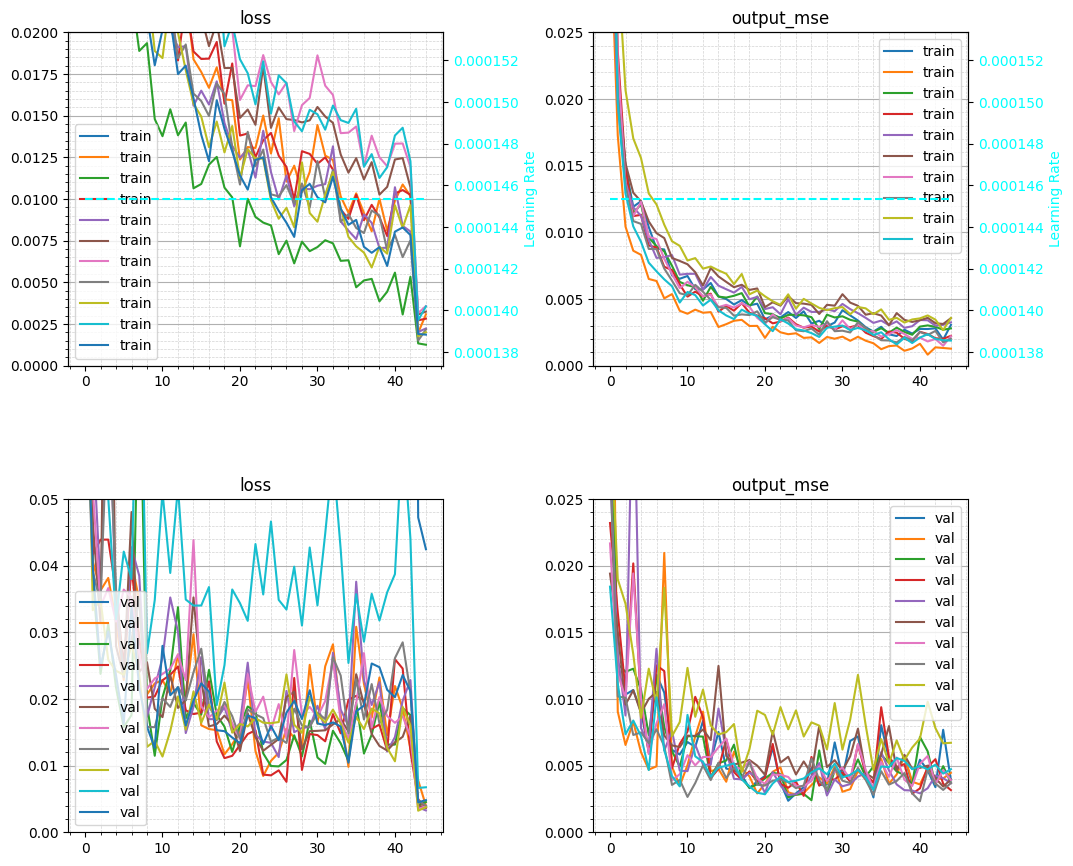

In [30]:
history = history_callback.history
history_1 = history_callback.history

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)

ax = ax.ravel()

keys = list(history.keys())
# for i in range(len(keys)):
#     print(f"{i}: {keys[i]}")
needed = [0, 1]
groups = [keys[i] for i in needed]

groups[1] = "output_mse"

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            i = j
            if key.startswith("val"):
                i+=2
            label = "val" if key.startswith("val") else "train"
            ax[i].plot(history[key], label=label)
            ax[i].set_title(groups[j])
            ax[i].minorticks_on()
            ax[i].grid(True, axis="y")
            ax[i].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[i].legend()
            break

ylim_list = [
    (0, 0.02),
    (0, 0.025),
    (0, 0.05),
    (0, 0.025),
]
for i in range(len(ylim_list)):
    # l, u = ylim_list[i]
    ax[i].set_ylim(ylim_list[i])

learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")

ax[0].legend(loc='lower left')

# ax[1].text(20 ,0,f"OverSampling max {upper}, v2S", rotation=90, ha='center')

# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



plt.savefig(f"{folder_path}/{name_template}.png")

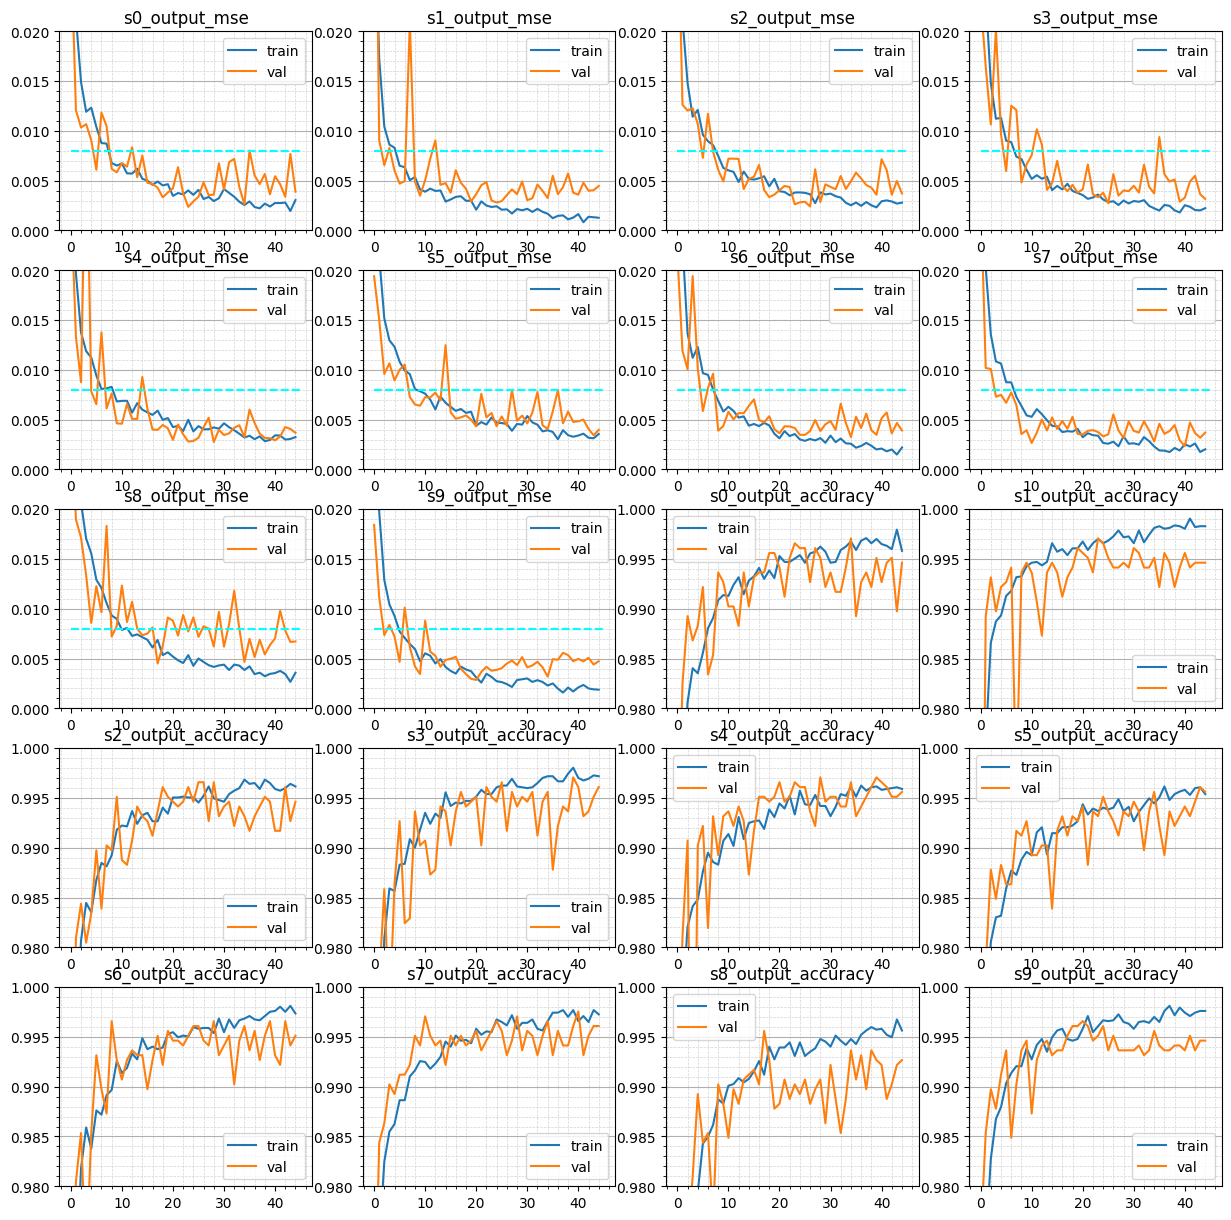

In [31]:
needed = np.array(keys)[range(11, 30, 2)]

fig, ax = plt.subplots(5, 4, figsize=(15, 15))

ax = ax.ravel()

for i in range(10):
    for key in keys:
        if key.endswith(needed[i]):
            label = "val" if key.startswith("val") else "train"
            ax[i].plot(history[key], label=label)
            ax[i].set_title(needed[i])
            ax[i].minorticks_on()
            ax[i].grid(True, axis="y")
            ax[i].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[i].legend()
            ax[i].set_ylim(0, 0.02)
            ax[i].hlines(0.008, 0, len(history[key]), colors="cyan", linestyles="dashed")

needed = np.array(keys)[range(12, 31, 2)]
for i in range(10):
    for key in keys:
        if key.endswith(needed[i]):
            label = "val" if key.startswith("val") else "train"
            ax[i+10].plot(history[key], label=label)
            ax[i+10].set_title(needed[i])
            ax[i+10].minorticks_on()
            ax[i+10].grid(True, axis="y")
            ax[i+10].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[i+10].legend()
            ax[i+10].set_ylim(0.98, 1)
            ax[i+10].hlines(0.008, 0, len(history[key]), colors="cyan", linestyles="dashed")

In [32]:
old_csv_df = csv_df

In [33]:
dataset_dir = "/home/ppxst5/mlis2_project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["angle"], inplace=True)
csv_df = csv_df[csv_df.index.isin(old_csv_df.index)]

X = np.array(csv_df.index)
y = np.array(csv_df["speed"])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=rs
)

X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(enhance_red, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=False)

# model = keras.models.load_model("/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Models/speed_model_20250307_1641/speed_model_20250307_1641.keras")

pred = model.predict(val_ds)

2069/2069 [==============================] - 44s 19ms/step


In [34]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = (pred[key][:, 0])
    y_pred.append(temp)

y_pred_mean = np.mean(y_pred, axis=0)

# y_pred.append(y_pred_mean)

y_pred = np.array(y_pred)
y_pred = y_pred-0.5

y_pred = y_pred.T

def y_pred_map(y_pred):
    if abs(np.mean(y_pred)) > 0.35:
        return np.sign(np.mean(y_pred)) * 0.5 + 0.5
        return round(np.mean(y_pred), 1)+0.5
    else:
        return np.mean(y_pred)+0.5


y_pred_2 = []

for i in range(len(y_pred)):
    y_pred_2.append(y_pred_map(y_pred[i]))


y_pred_mean =(np.mean(y_pred, axis=1)>0).astype(int)

speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, 

In [35]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = (pred[key][:, 0])
    y_pred.append(temp)

y_pred_mean = np.mean(y_pred, axis=0)

# y_pred.append(y_pred_mean)

y_pred = np.array(y_pred)
y_pred = y_pred-0.5

y_pred = y_pred.T

def y_pred_map(y_pred, threshold):
    if abs(np.mean(y_pred)) > threshold:
        return np.sign(np.mean(y_pred)) * 0.5 + 0.5
        return round(np.mean(y_pred), 1)+0.5
    else:
        return np.mean(y_pred)+0.5


threshold = 0.2

while True:
    y_pred_2 = []

    for i in range(len(y_pred)):
        y_pred_2.append(y_pred_map(y_pred[i], threshold))

    print(f"Threshold: {threshold:.2f}", end="    ")
    print(sum((y_val - y_pred_2)**2)/len(y_val))

    threshold += 0.02
    if threshold > 0.5:
        break

speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, Threshold: 0.20    0.008010406168417578
Threshold: 0.22    0.007772336653447971
Threshold: 0.24    0.007809746582689514
Threshold: 0.26    0.007809746582689514
Threshold: 0.28    0.007836627780757414
Threshold: 0.30    0.007858274725565825
Threshold: 0.32    0.007744352413322915
Threshold: 0.34    0.007757047781069678
Threshold: 0.36    0.007757047781069678
Threshold: 0.38    0.007757047781069678
Threshold: 0.40    0.007686404072270434
Threshold: 0.42    0.007550295035835378
Threshold: 0.44    0.007560384639647848
Threshold: 0.46    0.00751616055394872
Threshold: 0.48    0.007474159346908395


speed0_output, speed1_output, speed2_output, speed3_output, speed4_output, speed5_output, speed6_output, speed7_output, speed8_output, speed9_output, 
[1 1 1 ... 0 0 1]


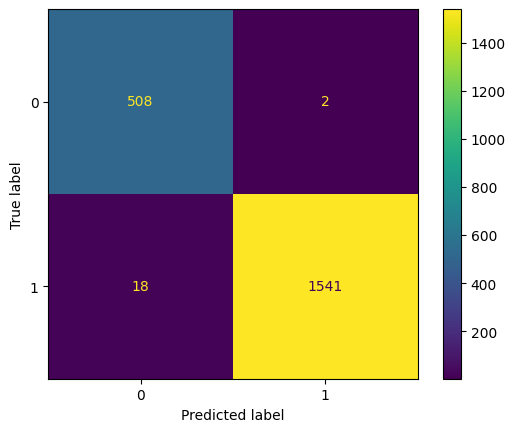

IndexError: index 20 is out of bounds for axis 0 with size 20

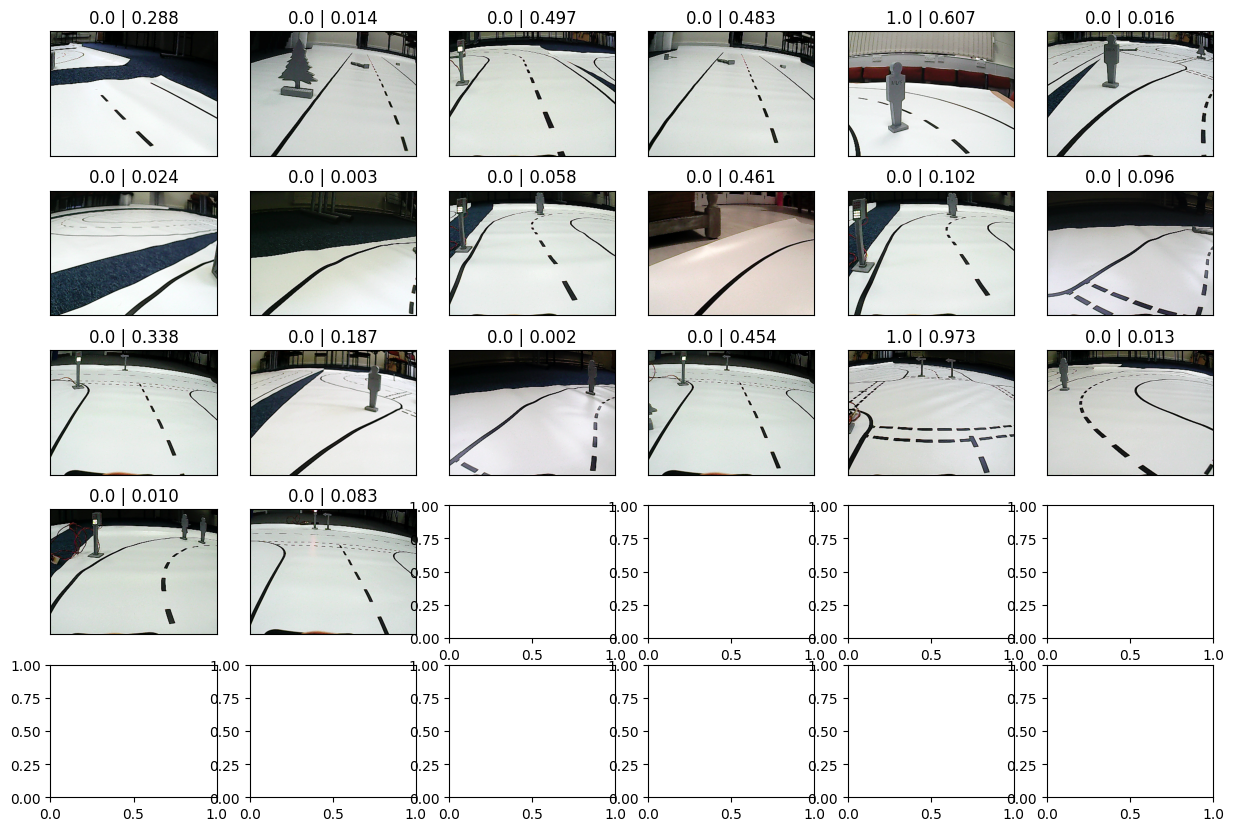

In [36]:
y_pred = []
for key in pred.keys():
    print(key, end=", ")
    temp = (pred[key][:, 0])
    y_pred.append(temp)

print()

y_pred = np.mean(y_pred, axis=0)
y_pred_value = y_pred

y_pred = (y_pred > 0.5).astype(int)
y_val

print(y_pred)

cm = sklearn.metrics.confusion_matrix(y_val, y_pred)

disp = sklearn.metrics.ConfusionMatrixDisplay(cm)

disp.plot()

plt.savefig('confusion_matrix.png')
plt.show()

wrong_id = []
wrong_label = []
wrong_pred = []
wrong_pred_values = []

for i in range(len(y_pred)):
    if y_pred[i] != y_val[i]:
        wrong_id.append(X_val[i])
        wrong_label.append(int(y_val[i]))
        wrong_pred.append(y_pred[i])
        wrong_pred_values.append(y_pred_value[i])
        # print(f"Id: {X_val[i]:5d}, Label: {int(y_val[i])}, Pred: {y_pred[i]}")

wrong_df = pd.DataFrame({'id':wrong_id, 'label': wrong_label, 'pred': wrong_pred, 'value': wrong_pred_values})
wrong_df.set_index('id', inplace=True)
wrong_df.sort_index(inplace=True)
# print(wrong_df)

fig, ax = plt.subplots(5, 6, figsize=(15, 10))
ax = ax.ravel()

for i in range(len(ax)):
    img_path, _ = image_id_to_path(wrong_df.index[i], 1)
    img = Image.open(img_path.numpy())
    ax[i].imshow(img)
    ax[i].set_title(f"{wrong_df.loc[wrong_df.index[i]]['pred']} | {wrong_df.loc[wrong_df.index[i]]['value']:.3f}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])